In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

pd.set_option("display.max_columns", None)

print('success')

success


### Processing images

We load the train,test,val images here

In [8]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [9]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
17696,fffb900a92289a33.jpg,[healthy]
17697,fffc488fa4c0e80c.jpg,[scab]
17698,fffc94e092a59086.jpg,[rust]
17699,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2029
frog_eye_leaf_spot    4125
healthy               4387
powdery_mildew        1226
rust                  1965
scab                  5442
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

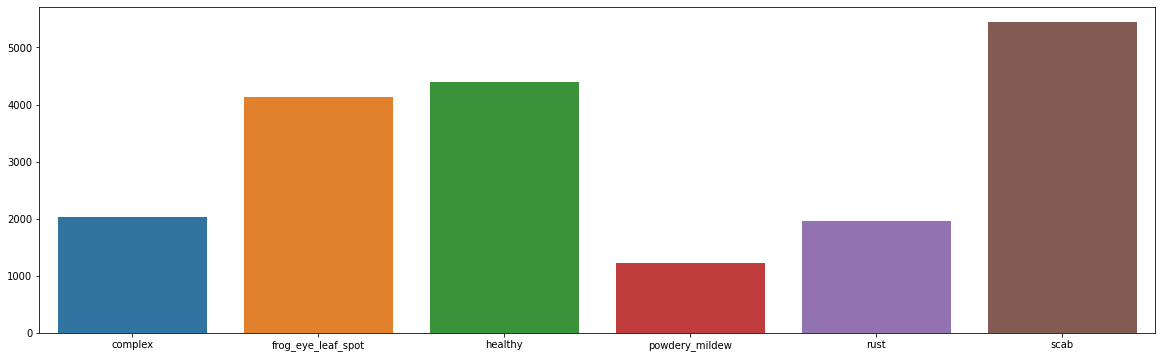

In [10]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

### Viewing some images

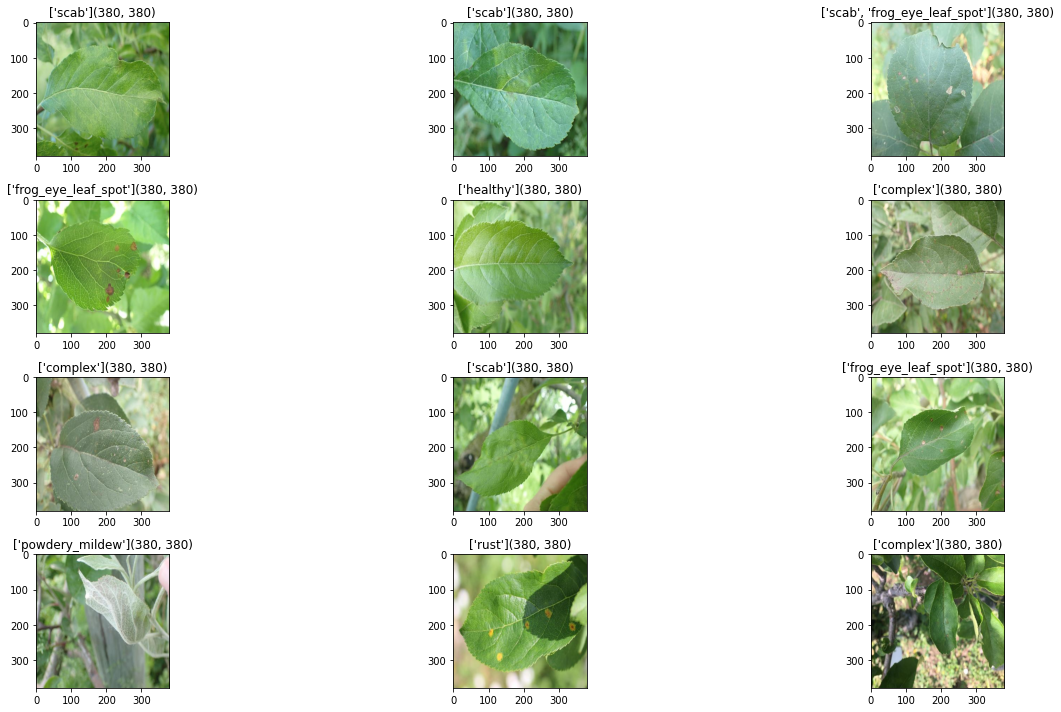

In [11]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, len(list(train['image'])))
    sample = os.path.join('./train_images380/', train['image'][rand])
    
    img = Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=5,
                            zoom_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    train,
    directory='./train_images380',
    subset='training',
    x_col='image',
    y_col='labels',
    target_size=(380,380),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

#'../input/plant-pathology-2021-fgvc8/train_images'
valid_generator = datagen.flow_from_dataframe(
    train,
    directory='./train_images380',
    subset='validation',
    x_col='image',
    y_col='labels',
    target_size=(380,380),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

Found 15931 validated image filenames belonging to 6 classes.
Found 1770 validated image filenames belonging to 6 classes.


In [34]:
# img_augmentation = tf.keras.Sequential(
#     [
#         keras.layers.RandomRotation(factor=0.15),
#         keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#         keras.layers.RandomFlip(),
#         keras.layers.RandomContrast(factor=0.1),
#     ],
#     name="img_augmentation",
# )

In [13]:
model=keras.Sequential()
model.add(keras.layers.Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(380,380,3)))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(6, 
    kernel_initializer=keras.initializers.RandomUniform(seed=1200),
    bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid'))


print(model.output)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='dense_top/Sigmoid:0', description="created by layer 'dense_top'")
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 380, 380, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 190, 190, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 190, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 95, 95, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 

In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(
#     physical_devices[0], enable='True'
# )

# import PIL.Image

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [14]:
# from tensorflow.keras.callbacks import EarlyStopping
import PIL
f1 = tfa.metrics.F1Score(num_classes=6,average='macro')


model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',f1])
# callbacks = keras.callbacks.EarlyStopping(monitor='f1_score', patience=4, mode='max', restore_best_weights=True)
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=15,
                    steps_per_epoch=train_generator.samples//256, # = 58
                    validation_steps=valid_generator.samples//128,)
                    # callbacks=callbacks)


Epoch 1/15


2022-03-24 21:05:01.325554: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-24 21:05:01.787858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.2792 - f1_score: 0.1402

2022-03-24 21:08:58.262963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 245s 4s/step - loss: 0.4615 - accuracy: 0.2792 - f1_score: 0.1402 - val_loss: 0.4349 - val_accuracy: 0.3606 - val_f1_score: 0.1859
Epoch 2/15
62/62 [==============================] - 233s 4s/step - loss: 0.4346 - accuracy: 0.3014 - f1_score: 0.1529 - val_loss: 0.4100 - val_accuracy: 0.3245 - val_f1_score: 0.1391
Epoch 3/15
62/62 [==============================] - 220s 4s/step - loss: 0.4192 - accuracy: 0.3377 - f1_score: 0.2400 - val_loss: 0.4159 - val_accuracy: 0.3486 - val_f1_score: 0.1703
Epoch 4/15
62/62 [==============================] - 250s 4s/step - loss: 0.4170 - accuracy: 0.3448 - f1_score: 0.2454 - val_loss: 0.4049 - val_accuracy: 0.3750 - val_f1_score: 0.2734
Epoch 5/15
62/62 [==============================] - 305s 5s/step - loss: 0.4052 - accuracy: 0.3790 - f1_score: 0.3097 - val_loss: 0.4111 - val_accuracy: 0.3750 - val_f1_score: 0.3182
Epoch 6/15
62/62 [==============================] - 178s 3s/step - loss: 0.4083 - accuracy: 0.37

In [24]:
# test_data = datagen.flow_from_dataframe(
#     test,
#     directory = './test_size256_images',
#     x_col="image",
#     y_col= None,
#     color_mode="rgb",
#     target_size = (256,256),
#     classes=None,
#     class_mode=None,
#     batch_size=32,
#     shuffle=False,
#     seed=40,
# )

test_data = datagen.flow_from_dataframe(
    test,
    directory = './test_images380',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (380,380),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

# train_generator = datagen.flow_from_dataframe(
#     train,
#     directory='./train_images',
#     subset='training',
#     x_col='image',
#     y_col='labels',
#     target_size=(224,224),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=64,
#     shuffle=True,
#     seed=444
#     )


preds = model.predict(test_data)
print(preds)
preds = preds.tolist()

# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
threshold = {0: 0.26, # Complex
             5: 0.61, # scab
             1: 0.7, # frog eye leaf spot
             4: 0.5, # rust
             3: 0.5, # powdery mildew
             2: 0.3} #healthy

             
# Can set different threshold here
indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
print(indices[:10])

Found 931 validated image filenames.
[[0.00225172 0.0457648  0.17133904 0.00755131 0.0954032  0.39720932]
 [0.03998581 0.14177918 0.00083039 0.00280962 0.27893084 0.01766981]
 [0.04972344 0.5652469  0.01657008 0.08745165 0.03749116 0.46013662]
 ...
 [0.0918022  0.35029477 0.02234069 0.01123952 0.08217137 0.20671915]
 [0.01321009 0.03677468 0.23615281 0.00495831 0.2570383  0.35959733]
 [0.03056407 0.2402253  0.20519294 0.02141723 0.02264925 0.38557705]]
[[5], [4], [1], [1], [5], [4], [2], [4], [2], [4]]


In [25]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels[:10])

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['scab', 'rust', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'scab', 'rust', 'healthy', 'rust', 'healthy', 'rust']


In [26]:
actuallabels = list(test['labels'])
print(actuallabels[:10])

['healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'frog_eye_leaf_spot', 'scab', 'rust', 'healthy', 'frog_eye_leaf_spot', 'scab', 'scab']


In [27]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(actuallabels,testlabels)
print(f"Test accuracy score: {accuracy}")

Test accuracy score: 0.5424274973147154


In [29]:
actual_test = pd.read_csv('sample_submission.csv')

In [48]:
for img_name in tqdm(actual_test['image']):
    path = './actual_test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((380,380))
        img.save(f'./actual_test_images/{img_name}')

100%|██████████| 3/3 [00:00<00:00,  6.78it/s]


In [31]:
actual_test_data = datagen.flow_from_dataframe(
    actual_test,
    directory = './actual_test_images',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (380,380),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

actual_preds = model.predict(actual_test_data)
print(actual_preds)
actual_preds = actual_preds.tolist()

# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
threshold = {0: 0.26, # Complex
             5: 0.61, # scab
             1: 0.7, # frog eye leaf spot
             4: 0.5, # rust
             3: 0.5, # powdery mildew
             2: 0.3} #healthy

             
# Can set different threshold here
indices = []
for pred in actual_preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
print(indices)

Found 3 validated image filenames.
[[0.00109181 0.00084057 0.20466545 0.00479949 0.78259766 0.28966954]
 [0.34206405 0.45278743 0.01013521 0.11293902 0.09910273 0.18558347]
 [0.0169368  0.19765083 0.16010019 0.0156516  0.06949074 0.2560975 ]]
[[4], [0], [5]]


In [32]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

actualtestlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    actualtestlabels.append(' '.join(temp))

print(actualtestlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['rust', 'complex', 'scab']


In [33]:
sub = pd.read_csv('./sample_submission.csv')
sub['labels'] = actualtestlabels
sub.to_csv('submission.csv', index=False)
sub

,image,labels
0,85f8cb619c66b863.jpg,rust
1,ad8770db05586b59.jpg,complex
2,c7b03e718489f3ca.jpg,scab
